# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import pandas as pd
from datetime import datetime as DT

In [2]:
from imod import msw
from imod import mf6
import primod

In [3]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM

In [4]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)

<module 'WS_Mdl.utils_imod' from 'C:\\Users\\Karam014\\OneDrive - Universiteit Utrecht\\WS_Mdl\\code\\WS_Mdl\\utils_imod.py'>

In [5]:
# Import sfrmaker and other necessary packages for SFR network creation
import sfrmaker as sfr
import geopandas as gpd
import numpy as np

In [6]:
import fiona

In [7]:
sfr.__version__

'0.11.3'

In [8]:
from WS_Mdl.utils import bold, style_reset

# Options

In [9]:
Pa_GPkg = r"C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\acceptatiedatabase.gdb"
layer = 'hydroobject'

In [10]:
MdlN = 'NBr33'

In [11]:
U.set_verbose(False)

In [12]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax = [float(i) for i in d_INI['WINDOW'].split(',')]
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

# Load GPkg. Select correct layer. Limit to Mdl Aa.

After this methodology is established, a function should be created that'll take in either a GeoPackage with a specified layer or a shapefile (single layer).<br>
Other Params like the Cols to be used for the SFR network creation, should be provided as well. A .toml file could be a good idea.

## Load

In [13]:
# First, let's see what layers are available in the GeoPackage
layers = fiona.listlayers(Pa_GPkg)
print("Available layers in GeoPackage:")
for i, L in enumerate(layers):
    print(f"  {i+1}. {L}")

Available layers in GeoPackage:
  1. gemaal
  2. brug
  3. DuikerSifonHevel
  4. afsluitmiddel
  5. LEGGER_VASTGESTELD_WATERLOOP_CATEGORIE_A
  6. hydroobject
  7. stuw
  8. sturing
  9. vispassage


In [14]:
# Read the hydroobject layer specifically
GDF1 = gpd.read_file(Pa_GPkg, layer=layer)

In [15]:
print(f"\nHydroobject layer loaded successfully!\nNumber of features: {bold}{len(GDF1)}{style_reset}\nCRS: {bold}{GDF1.crs}{style_reset}\nGeometry types: {GDF1.geometry.geom_type.value_counts()}")
print(*GDF1.columns, sep=' | ')


Hydroobject layer loaded successfully!
Number of features: 40811
CRS: EPSG:28992
Geometry types: MultiLineString    40811
Name: count, dtype: int64
CODE | NAAM | STATUSLEGGERWATERSYSTEEM | STATUSOBJECT | DRAINEERT | GETIJDEBEINVLOED | RUIMTELIJKEAFBAKENINGBEKEND | NAMESPACE | DETAILNIVEAUGEOMETRIE | LVPUBLICATIEDATUM | CREATED_USER | CREATED_DATE | LAST_EDITED_USER | LAST_EDITED_DATE | WS_BRONINWINNING | WS_DATUMINWINNING | WS_PRECISIE | WS_IDEALISATIE | WS_BETROUWBAARHEID | WS_CALAMITEITENPLAN | WS_KWALITEITSLABEL | WS_HYDROOBJECT_SOORT | WS_BH_BOVENSTROOMS | WS_BH_BENEDENSTROOMS | WS_HGT_MAAIVELD_BOVS | WS_HGT_MAAIVELD_BENS | WS_INDICATIE_SCHOUW_L | WS_WIJZEINWINNING | WS_HGT_BESCHOEIING_LINKS | WS_HGT_BESCHOEIING_RECHTS | WS_HGT_ONDERK_BES_LINKS | WS_HGT_ONDERK_BES_RECHTS | WS_HGT_INSTEEK_LINKERZIJDE | WS_HGT_INSTEEK_RECHTERZIJDE | WS_OPMERKING_L | WS_HGT_INSTEEK_LI_L | WS_HGT_INSTEEK_RE_L | WS_BHGT_ACCPROF_LI_L | WS_BHGT_ACCPROF_RE_L | WS_ONDERWATERTALUD_LI_L | WS_ONDERWATERTALUD_

## Explore

In [16]:
GDF1.head(3)

,CODE,NAAM,STATUSLEGGERWATERSYSTEEM,STATUSOBJECT,DRAINEERT,GETIJDEBEINVLOED,RUIMTELIJKEAFBAKENINGBEKEND,NAMESPACE,DETAILNIVEAUGEOMETRIE,LVPUBLICATIEDATUM,...,ONTSTAANSWIJZE,DATUMINWINNING,INWINNENDEINSTANTIE,METENDEINSTANTIE,INWINNINGSMETHODE,DIMENSIE,NAUWKEURIGHEIDXY,NAUWKEURIGHEIDZ,SHAPE_Length,geometry
0,OWL14602,Onbekend,4.0,3.0,NaN,None,None,None,NaN,NaT,...,NaN,NaT,None,None,NaN,NaN,NaN,NaN,253.308288,"MULTILINESTRING ((85136.766 396597.503, 85131...."
1,OWL20045,Onbekend,1.0,3.0,NaN,None,None,None,NaN,NaT,...,NaN,NaT,None,None,NaN,NaN,NaN,NaN,182.535567,"MULTILINESTRING ((100018.116 384285.028, 10001..."
2,OWL16386,Onbekend,1.0,3.0,NaN,None,None,None,NaN,NaT,...,NaN,NaT,None,None,NaN,NaN,NaN,NaN,153.199875,"MULTILINESTRING ((100582.34 384508.938, 100583..."


In [17]:
GDF1.describe(include='all')

,CODE,NAAM,STATUSLEGGERWATERSYSTEEM,STATUSOBJECT,DRAINEERT,GETIJDEBEINVLOED,RUIMTELIJKEAFBAKENINGBEKEND,NAMESPACE,DETAILNIVEAUGEOMETRIE,LVPUBLICATIEDATUM,...,ONTSTAANSWIJZE,DATUMINWINNING,INWINNENDEINSTANTIE,METENDEINSTANTIE,INWINNINGSMETHODE,DIMENSIE,NAUWKEURIGHEIDXY,NAUWKEURIGHEIDZ,SHAPE_Length,geometry
count,40791,39139,40060.000000,40424.000000,0.0,979,6,0,0.0,0,...,6.0,0,0,0,0.0,0.0,0.0,0.0,40811.000000,40811
unique,40752,3885,NaN,NaN,NaN,2,2,0,NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,40810
top,OVK10006,Onbekend,NaN,NaN,NaN,n,j,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTILINESTRING ((130009.26700000092 392638.41...
freq,3,24297,NaN,NaN,NaN,978,5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
mean,NaN,NaN,1.286670,3.040397,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,283.421513,NaN
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.690903,NaN
25%,NaN,NaN,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,106.022157,NaN
50%,NaN,NaN,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,208.817862,NaN
75%,NaN,NaN,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,369.472678,NaN
max,NaN,NaN,5.000000,99.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,28611.715573,NaN


In [18]:
#666 columns need to be reviewed later!!!

In [19]:
GDF1.WS_BH_BOVENSTROOMS.value_counts()

WS_BH_BOVENSTROOMS
-1.50     119
-1.40      97
-0.80      93
 5.00      90
-1.00      83
         ... 
 23.19      1
 16.92      1
 12.18      1
 24.52      1
 15.90      1
Name: count, Length: 1977, dtype: int64

In [20]:
for i, col in enumerate(GDF1.columns):
    print(f"{i}: {col}")

0: CODE
1: NAAM
2: STATUSLEGGERWATERSYSTEEM
3: STATUSOBJECT
4: DRAINEERT
5: GETIJDEBEINVLOED
6: RUIMTELIJKEAFBAKENINGBEKEND
7: NAMESPACE
8: DETAILNIVEAUGEOMETRIE
9: LVPUBLICATIEDATUM
10: CREATED_USER
11: CREATED_DATE
12: LAST_EDITED_USER
13: LAST_EDITED_DATE
14: WS_BRONINWINNING
15: WS_DATUMINWINNING
16: WS_PRECISIE
17: WS_IDEALISATIE
18: WS_BETROUWBAARHEID
19: WS_CALAMITEITENPLAN
20: WS_KWALITEITSLABEL
21: WS_HYDROOBJECT_SOORT
22: WS_BH_BOVENSTROOMS
23: WS_BH_BENEDENSTROOMS
24: WS_HGT_MAAIVELD_BOVS
25: WS_HGT_MAAIVELD_BENS
26: WS_INDICATIE_SCHOUW_L
27: WS_WIJZEINWINNING
28: WS_HGT_BESCHOEIING_LINKS
29: WS_HGT_BESCHOEIING_RECHTS
30: WS_HGT_ONDERK_BES_LINKS
31: WS_HGT_ONDERK_BES_RECHTS
32: WS_HGT_INSTEEK_LINKERZIJDE
33: WS_HGT_INSTEEK_RECHTERZIJDE
34: WS_OPMERKING_L
35: WS_HGT_INSTEEK_LI_L
36: WS_HGT_INSTEEK_RE_L
37: WS_BHGT_ACCPROF_LI_L
38: WS_BHGT_ACCPROF_RE_L
39: WS_ONDERWATERTALUD_LI_L
40: WS_ONDERWATERTALUD_RE_L
41: WS_HGT_BESCHOEIING_LI_L
42: WS_HGT_BESCHOEIING_RE_L
43: WS_HGT_OND

In [21]:
GDF1.sort_values('WS_BH_BOVENSTROOMS', inplace=True, ascending=False)

In [22]:
GDF1[['WS_BH_BOVENSTROOMS', 'WS_BH_BENEDENSTROOMS', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']].head(10)

,WS_BH_BOVENSTROOMS,WS_BH_BENEDENSTROOMS,WS_BH_BOVENSTROOMS_L,WS_BH_BENEDENSTROOMS_L
30266,99.0,99.0,NaN,NaN
30484,99.0,99.0,NaN,NaN
30485,99.0,99.0,NaN,NaN
30495,99.0,99.0,NaN,NaN
30491,99.0,99.0,NaN,NaN
30311,99.0,99.0,NaN,NaN
30310,99.0,99.0,NaN,NaN
30309,99.0,99.0,NaN,NaN
30302,99.0,99.0,NaN,NaN
28098,99.0,99.0,NaN,NaN


Columns that seem useful:
1. CODE: as unique ID.
2. NAAM: as name.
3. WS_BH_BOVENSTROOMS: width upstream
4. WS_BH_BENEDENSTROOMS: width downstream
5. WS_HGT_MAAIVELD_BOVS: ground level elevation upstream
6. WS_HGT_MAAIVELD_BENS: ground level elevation downstream
7. WS_HGT_INSTEEK_LINKERZIJDE: left bank elevation
8. WS_HGT_INSTEEK_RECHTERZIJDE: right bank elevation
9. WS_TALUD_LINKS_L: left bank slope
10. WS_TALUD_RECHTS_L: right bank slope
11. WS_BODEMBREEDTE_L: bottom width
12. WS_BH_BOVENSTROOMS_L: width upstream (seems like a duplicate of 2, need to check though)
13. WS_BH_BENEDENSTROOMS_L: width downstream (seems like a duplicate of 3, need to check though)
14. 

Plot of line geometry in the whole area.


<Axes: >

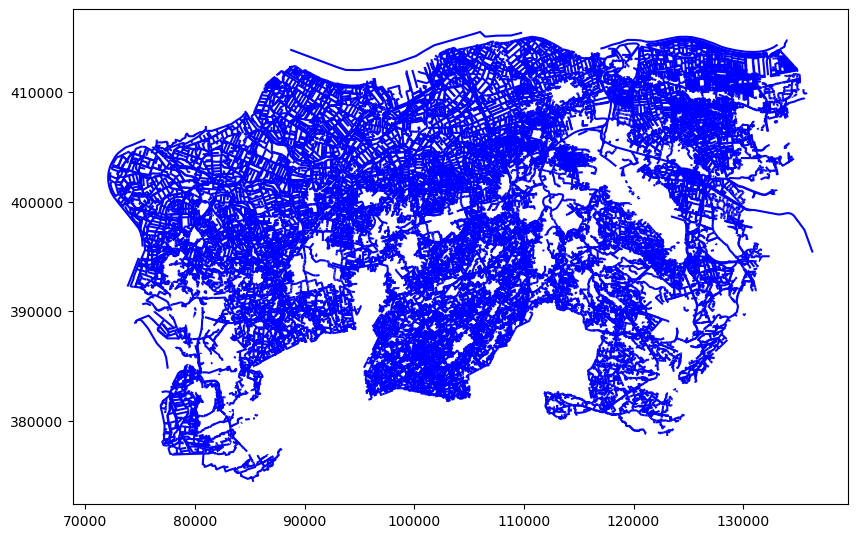

In [23]:
print('Plot of line geometry in the whole area.')
GDF1.plot(figsize=(10, 10), color='blue', edgecolor='black')

## Limit

In [26]:
# Limit GDF to model area bounds
print(f"Model area bounds: Xmin: {Xmin:10}, Xmax: {Xmax:10} | Ymin: {Ymin:10}, Ymax: {Ymax:10}\n")
print(f"Original dataset: {bold}{len(GDF1):10}{style_reset} features\t| Bounds: {GDF1.total_bounds}")

# Create bounding box for clipping
from shapely.geometry import box
model_bbox = box(Xmin, Ymin, Xmax, Ymax)

# Filter GDF to model area using spatial intersection
GDF1_clipped = GDF1[GDF1.geometry.intersects(model_bbox)].copy()

print(f"Filtered dataset: {bold}{len(GDF1_clipped):10}{style_reset} features\t| Bounds: {GDF1_clipped.total_bounds}")
print(f"Reduction: {bold}{len(GDF1)-len(GDF1_clipped):,}{style_reset} features removed ({(len(GDF1)-len(GDF1_clipped))/len(GDF1)*100:.1f}%) | ✓ GDF updated to model area extent")
print(f"✓ Network length: {GDF1.geometry.length.sum()/1000:.1f} km within model area")

# Update GDF to use the clipped version
GDF1 = GDF1_clipped

Model area bounds: Xmin:   113100.0, Xmax:   125100.0 | Ymin:   387600.0, Ymax:   396200.0

Original dataset:      40811 features	| Bounds: [ 72084.4984 374439.429  136342.416  415470.5641]
Filtered dataset:       2362 features	| Bounds: [112846.651  387082.9701 126531.775  396675.632 ]
Reduction: 38,449 features removed (94.2%) | ✓ GDF updated to model area extent
✓ Network length: 11566.7 km within model area


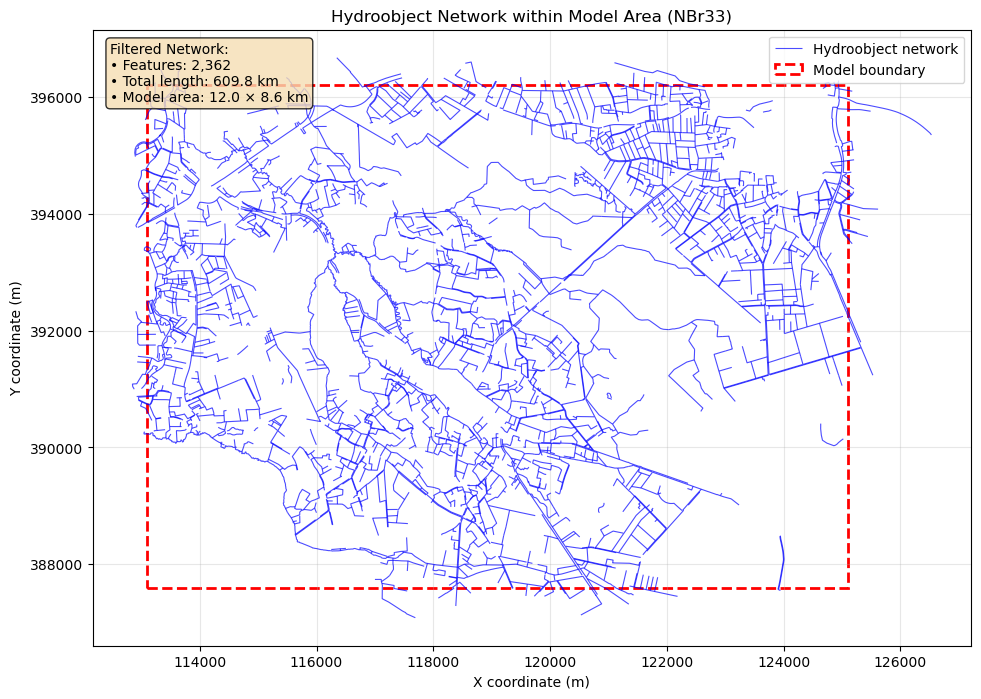

In [27]:
# Plot the filtered hydroobject network within model area
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the filtered GDF
GDF1.plot(ax=ax, color='blue', linewidth=0.8, alpha=0.7, label='Hydroobject network')

# Add model boundary rectangle
from matplotlib.patches import Rectangle
model_rect = Rectangle((Xmin, Ymin), Xmax-Xmin, Ymax-Ymin, 
                      linewidth=2, edgecolor='red', facecolor='none', 
                      linestyle='--', label='Model boundary')
ax.add_patch(model_rect)

ax.set_title(f'Hydroobject Network within Model Area ({MdlN})')
ax.set_xlabel('X coordinate (m)')
ax.set_ylabel('Y coordinate (m)')
ax.legend()

# Add statistics text
stats_text = f"""Filtered Network:
• Features: {len(GDF1):,}
• Total length: {GDF1.geometry.length.sum()/1000:.1f} km
• Model area: {(Xmax-Xmin)/1000:.1f} × {(Ymax-Ymin)/1000:.1f} km"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add grid
ax.grid(True, alpha=0.3)

# Check primary SW network shapefile.

## Load

In [28]:
# Read the hydroobject layer specifically
primary = 'LEGGER_VASTGESTELD_WATERLOOP_CATEGORIE_A'
GDF = gpd.read_file(Pa_GPkg, layer=primary)

In [29]:
print(f"\nHydroobject layer loaded successfully!\nNumber of features: {bold}{len(GDF)}{style_reset}\nCRS: {bold}{GDF.crs}{style_reset}\nGeometry types: {GDF.geometry.geom_type.value_counts()}")
print(*GDF.columns, sep=' | ')


Hydroobject layer loaded successfully!
Number of features: 12864
CRS: EPSG:28992
Geometry types: MultiLineString    12864
Name: count, dtype: int64
CODE | WS_STATUS_L | WS_LEGGERCATEGORIE_L | WS_LEGGERBRON_L | DATUM_VASTGESTELD | LEGGER_KENMERK | WS_ONDERHOUDSPLICHTIGE_L | WS_ONDERHOUDSPLICHT_L | WS_BODEMBREEDTE_L | WS_BH_BOVENSTROOMS_L | WS_BH_BENEDENSTROOMS_L | WS_BODBREE_ACCPROF_LI_L | WS_BODBREE_ACCPROF_RE_L | WS_HGT_INSTEEK_LI_L | WS_HGT_INSTEEK_RE_L | WS_BHGT_ACCPROF_LI_L | WS_BHGT_ACCPROF_RE_L | WS_TALUD_LINKS_L | WS_TALUD_RECHTS_L | WS_TALUD_ACCPROF_LI_L | WS_TALUD_ACCPROF_RE_L | WS_ONDERWATERTALUD_LI_L | WS_ONDERWATERTALUD_RE_L | WS_HGT_BESCHOEIING_LI_L | WS_HGT_BESCHOEIING_RE_L | WS_HGT_ONDERK_BES_LI_L | WS_HGT_ONDERK_BES_RE_L | WS_HGT_INSTEEK_ACCPROF_LI_L | WS_HGT_INSTEEK_ACCPROF_RE_L | WS_BIJZ_FUNCTIE_L | WS_INHOUD_RETENTIE_L | WS_LENGTE_L | WS_OPW_BIJZ_PROF_L | WS_VW_BODEMBREEDTE_L | WS_VW_BH_BOVENSTROOMS_L | WS_VW_BH_BENEDENSTROOMS_L | WS_VW_TALUD_LINKS_L | WS_VW_TALUD_R

## Explore

In [30]:
GDF.head(3)

,CODE,WS_STATUS_L,WS_LEGGERCATEGORIE_L,WS_LEGGERBRON_L,DATUM_VASTGESTELD,LEGGER_KENMERK,WS_ONDERHOUDSPLICHTIGE_L,WS_ONDERHOUDSPLICHT_L,WS_BODEMBREEDTE_L,WS_BH_BOVENSTROOMS_L,...,WS_OMSCHRIJVING_TRAJECT_L,WS_LEGGERVERWIJZING_L,WS_HYPERLINK_PRO_OPW_L,WS_HYPERLINK_PRO_VW_L,WS_LEGGERBRON_OMW_L,WS_LEGGERBRON_WAW_L,WS_LEGGERBRON_COS_L,WS_HYPERLINK_BESLUIT_L,SHAPE_Length,geometry
0,OVK12326,"Vastgesteld, Besluit geverifieerd, ingemeten",Oppervlaktewaterlichamen,"11UT009138, kernregistratie",2021-03-30 00:00:00+00:00,"Waterschapsblad 2021, 4434",None,None,0.5,18.45,...,None,Niet van toepassing,None,None,None,None,None,None,103.786374,"MULTILINESTRING ((82178.821 382139.593, 82180...."
1,OVK21780,"Vastgesteld, Besluit geverifieerd, ingemeten",Oppervlaktewaterlichamen,Oude legger de gewijzigde Cruijslandpolders 19...,2021-03-30 00:00:00+00:00,"Waterschapsblad 2021, 4434",None,None,1.5,-1.64,...,None,Niet van toepassing,None,None,None,None,None,None,159.245366,"MULTILINESTRING ((87960.311 397958.808, 87960...."
2,OVK02233,"Vastgesteld, Ligging gewijzigd, tabel ongewijzigd",Oppervlaktewaterlichamen,None,2021-03-30 00:00:00+00:00,"Waterschapsblad 2021, 4434",None,None,0.6,2.78,...,None,Niet van toepassing,None,None,None,None,None,None,211.357944,"MULTILINESTRING ((111124.488 396263.763, 11113..."


In [31]:
GDF.describe(include='all')

,CODE,WS_STATUS_L,WS_LEGGERCATEGORIE_L,WS_LEGGERBRON_L,DATUM_VASTGESTELD,LEGGER_KENMERK,WS_ONDERHOUDSPLICHTIGE_L,WS_ONDERHOUDSPLICHT_L,WS_BODEMBREEDTE_L,WS_BH_BOVENSTROOMS_L,...,WS_OMSCHRIJVING_TRAJECT_L,WS_LEGGERVERWIJZING_L,WS_HYPERLINK_PRO_OPW_L,WS_HYPERLINK_PRO_VW_L,WS_LEGGERBRON_OMW_L,WS_LEGGERBRON_WAW_L,WS_LEGGERBRON_COS_L,WS_HYPERLINK_BESLUIT_L,SHAPE_Length,geometry
count,12864,12864,12864,1658,12864,8597,593,370,12782.000000,12784.000000,...,161,4645,161,160,195,32,624,148,12864.000000,12864
unique,12864,16,22,533,NaN,9,34,20,NaN,NaN,...,159,4,7,5,85,9,54,1,NaN,12864
top,OVK00584,"Vastgesteld, vigerende legger",Oppervlaktewaterlichamen,Zaagtandeffect,NaN,"Waterschapsblad 2021, 4434",Gemeente Breda,"Waterschap: nat profiel + 1m talud, Gemeente: ...",NaN,NaN,...,MD33.3-MD35.08,Niet van toepassing,nee,Profielen Vaarweg Mark en Dintel.PDF,AWW,666598,853332 - Verbeterde ligging op de kaart ten op...,https://zoek.officielebekendmakingen.nl/wsb-20...,NaN,MULTILINESTRING ((127000.11340000108 411147.18...
freq,1,10976,7985,193,NaN,5701,287,262,NaN,NaN,...,3,4640,122,76,17,14,353,148,NaN,1
mean,NaN,NaN,NaN,NaN,2018-08-27 23:50:35.820000+00:00,NaN,NaN,NaN,2.998175,1.814056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.521408,NaN
min,NaN,NaN,NaN,NaN,2010-11-16 00:00:00+00:00,NaN,NaN,NaN,0.010000,-5.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.785216,NaN
25%,NaN,NaN,NaN,NaN,2012-06-12 00:00:00+00:00,NaN,NaN,NaN,0.780000,-1.620000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.275084,NaN
50%,NaN,NaN,NaN,NaN,2021-03-30 00:00:00+00:00,NaN,NaN,NaN,1.300000,-0.640000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,218.364524,NaN
75%,NaN,NaN,NaN,NaN,2021-03-30 00:00:00+00:00,NaN,NaN,NaN,2.500000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,418.739355,NaN
max,NaN,NaN,NaN,NaN,2024-11-21 00:00:00+00:00,NaN,NaN,NaN,999.000000,26.650000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4873.399527,NaN


In [33]:
for i, col in enumerate(GDF.columns):
    print(f"{i}: {col}")

0: CODE
1: WS_STATUS_L
2: WS_LEGGERCATEGORIE_L
3: WS_LEGGERBRON_L
4: DATUM_VASTGESTELD
5: LEGGER_KENMERK
6: WS_ONDERHOUDSPLICHTIGE_L
7: WS_ONDERHOUDSPLICHT_L
8: WS_BODEMBREEDTE_L
9: WS_BH_BOVENSTROOMS_L
10: WS_BH_BENEDENSTROOMS_L
11: WS_BODBREE_ACCPROF_LI_L
12: WS_BODBREE_ACCPROF_RE_L
13: WS_HGT_INSTEEK_LI_L
14: WS_HGT_INSTEEK_RE_L
15: WS_BHGT_ACCPROF_LI_L
16: WS_BHGT_ACCPROF_RE_L
17: WS_TALUD_LINKS_L
18: WS_TALUD_RECHTS_L
19: WS_TALUD_ACCPROF_LI_L
20: WS_TALUD_ACCPROF_RE_L
21: WS_ONDERWATERTALUD_LI_L
22: WS_ONDERWATERTALUD_RE_L
23: WS_HGT_BESCHOEIING_LI_L
24: WS_HGT_BESCHOEIING_RE_L
25: WS_HGT_ONDERK_BES_LI_L
26: WS_HGT_ONDERK_BES_RE_L
27: WS_HGT_INSTEEK_ACCPROF_LI_L
28: WS_HGT_INSTEEK_ACCPROF_RE_L
29: WS_BIJZ_FUNCTIE_L
30: WS_INHOUD_RETENTIE_L
31: WS_LENGTE_L
32: WS_OPW_BIJZ_PROF_L
33: WS_VW_BODEMBREEDTE_L
34: WS_VW_BH_BOVENSTROOMS_L
35: WS_VW_BH_BENEDENSTROOMS_L
36: WS_VW_TALUD_LINKS_L
37: WS_VW_TALUD_RECHTS_L
38: WS_VW_BIJZ_PROF_L
39: WIJZIGING
40: SE_ANNO_CAD_DATA
41: CREATED_USER

In [ ]:
GDF[['WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L', 'WS_BODEMBREEDTE_L', 'WS_TALUD_LINKS_L', 'WS_TALUD_RECHTS_L']].head(10)

Columns that seem useful:
1. CODE: as unique ID.
2. WS_BH_BOVENSTROOMS_L: width upstream  
3. WS_BH_BENEDENSTROOMS_L: width downstream
4. WS_BODEMBREEDTE_L: bottom width
5. WS_HGT_INSTEEK_LI_L: left bank elevation (insteek)
6. WS_HGT_INSTEEK_RE_L: right bank elevation (insteek)
7. WS_TALUD_LINKS_L: left bank slope
8. WS_TALUD_RECHTS_L: right bank slope
9. WS_VW_BODEMBREEDTE_L: winter water level bottom width
10. WS_VW_BH_BOVENSTROOMS_L: winter water level width upstream
11. WS_VW_BH_BENEDENSTROOMS_L: winter water level width downstream
12. WS_VW_TALUD_LINKS_L: winter water level left bank slope
13. WS_VW_TALUD_RECHTS_L: winter water level right bank slope
14. WS_LENGTE_L: length
15. geometry: the spatial geometry

Plot of line geometry in the whole area.


<Axes: >

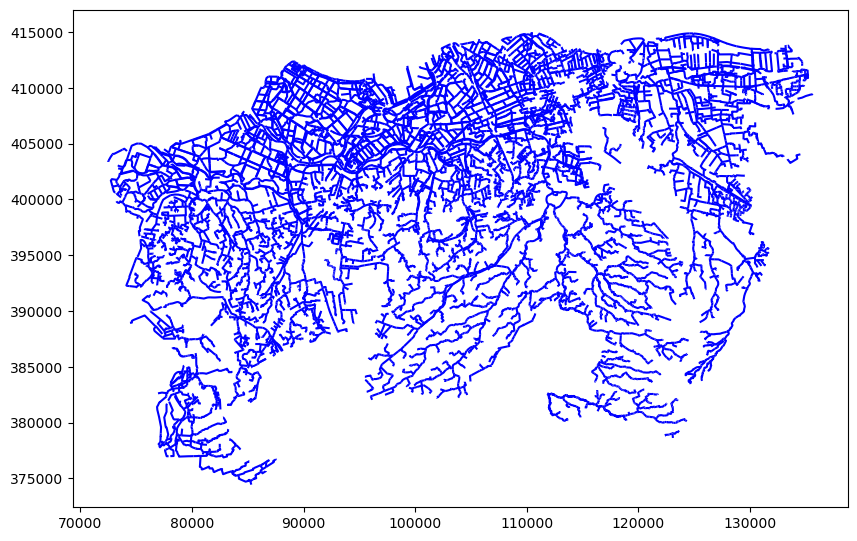

In [35]:
print('Plot of line geometry in the whole area.')
GDF.plot(figsize=(10, 10), color='blue', edgecolor='black')

## Limit

In [36]:
# Limit GDF to model area bounds
print(f"Model area bounds: Xmin: {Xmin:10}, Xmax: {Xmax:10} | Ymin: {Ymin:10}, Ymax: {Ymax:10}\n")
print(f"Original dataset: {bold}{len(GDF):10}{style_reset} features\t| Bounds: {GDF.total_bounds}")

# Create bounding box for clipping
from shapely.geometry import box
model_bbox = box(Xmin, Ymin, Xmax, Ymax)

# Filter GDF to model area using spatial intersection
GDF_clipped = GDF[GDF.geometry.intersects(model_bbox)].copy()

print(f"Filtered dataset: {bold}{len(GDF_clipped):10}{style_reset} features\t| Bounds: {GDF_clipped.total_bounds}")
print(f"Reduction: {bold}{len(GDF)-len(GDF_clipped):,}{style_reset} features removed ({(len(GDF)-len(GDF_clipped))/len(GDF)*100:.1f}%) | ✓ GDF updated to model area extent")
print(f"✓ Network length: {GDF.geometry.length.sum()/1000:.1f} km within model area")

# Update GDF to use the clipped version
GDF = GDF_clipped

Model area bounds: Xmin:   113100.0, Xmax:   125100.0 | Ymin:   387600.0, Ymax:   396200.0

Original dataset:      12864 features	| Bounds: [ 72496.125  374439.429  135610.2516 414969.973 ]
Filtered dataset:        591 features	| Bounds: [112885.761  387082.9701 125619.006  396480.772 ]
Reduction: 12,273 features removed (95.4%) | ✓ GDF updated to model area extent
✓ Network length: 3891.6 km within model area


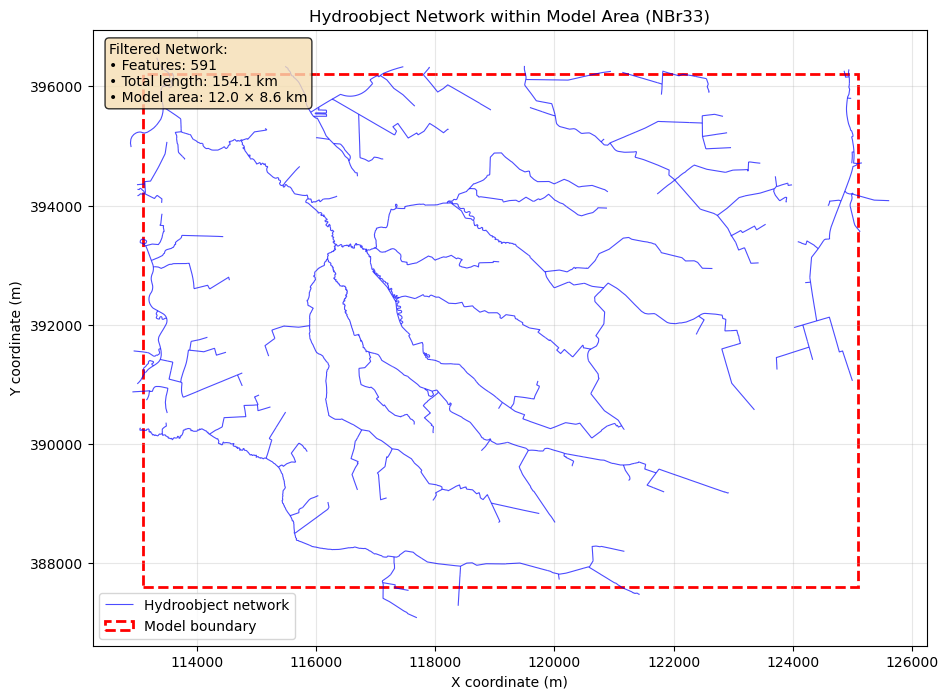

In [37]:
# Plot the filtered hydroobject network within model area
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the filtered GDF
GDF.plot(ax=ax, color='blue', linewidth=0.8, alpha=0.7, label='Hydroobject network')

# Add model boundary rectangle
from matplotlib.patches import Rectangle
model_rect = Rectangle((Xmin, Ymin), Xmax-Xmin, Ymax-Ymin, 
                      linewidth=2, edgecolor='red', facecolor='none', 
                      linestyle='--', label='Model boundary')
ax.add_patch(model_rect)

ax.set_title(f'Hydroobject Network within Model Area ({MdlN})')
ax.set_xlabel('X coordinate (m)')
ax.set_ylabel('Y coordinate (m)')
ax.legend()

# Add statistics text
stats_text = f"""Filtered Network:
• Features: {len(GDF):,}
• Total length: {GDF.geometry.length.sum()/1000:.1f} km
• Model area: {(Xmax-Xmin)/1000:.1f} × {(Ymax-Ymin)/1000:.1f} km"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add grid
ax.grid(True, alpha=0.3)

# Create Grid and Generate SFR Routing Network

In [38]:
help(sfr.Lines.from_dataframe)

Help on method from_dataframe in module sfrmaker.lines:

from_dataframe(
    df,
    id_column='id',
    routing_column='toid',
    arbolate_sum_column2='asum2',
    asum_units='km',
    width1_column='width1',
    width2_column='width2',
    width_units='meters',
    up_elevation_column='elevup',
    dn_elevation_column='elevdn',
    elevation_units='meters',
    geometry_column='geometry',
    name_column='name',
    crs=None,
    prjfile=None,
    **kwargs
) class method of sfrmaker.lines.Lines
    [summary]

    Parameters
    ----------
    df : DataFrame
        Pandas DataFrame or Geopandas GeoDataFrame
        with flowline information, including
        shapely :class:`LineStrings <LineString>` in a `'geometry'` column.
    id_column : str, optional
        Attribute field with line identifiers,
        by default 'id'
    routing_column : str, optional
        Attribute field with downstream routing connections,
        by default 'toid'
    arbolate_sum_column2 : str, option

In [39]:
GDF.columns

Index(['CODE', 'WS_STATUS_L', 'WS_LEGGERCATEGORIE_L', 'WS_LEGGERBRON_L',
       'DATUM_VASTGESTELD', 'LEGGER_KENMERK', 'WS_ONDERHOUDSPLICHTIGE_L',
       'WS_ONDERHOUDSPLICHT_L', 'WS_BODEMBREEDTE_L', 'WS_BH_BOVENSTROOMS_L',
       'WS_BH_BENEDENSTROOMS_L', 'WS_BODBREE_ACCPROF_LI_L',
       'WS_BODBREE_ACCPROF_RE_L', 'WS_HGT_INSTEEK_LI_L', 'WS_HGT_INSTEEK_RE_L',
       'WS_BHGT_ACCPROF_LI_L', 'WS_BHGT_ACCPROF_RE_L', 'WS_TALUD_LINKS_L',
       'WS_TALUD_RECHTS_L', 'WS_TALUD_ACCPROF_LI_L', 'WS_TALUD_ACCPROF_RE_L',
       'WS_ONDERWATERTALUD_LI_L', 'WS_ONDERWATERTALUD_RE_L',
       'WS_HGT_BESCHOEIING_LI_L', 'WS_HGT_BESCHOEIING_RE_L',
       'WS_HGT_ONDERK_BES_LI_L', 'WS_HGT_ONDERK_BES_RE_L',
       'WS_HGT_INSTEEK_ACCPROF_LI_L', 'WS_HGT_INSTEEK_ACCPROF_RE_L',
       'WS_BIJZ_FUNCTIE_L', 'WS_INHOUD_RETENTIE_L', 'WS_LENGTE_L',
       'WS_OPW_BIJZ_PROF_L', 'WS_VW_BODEMBREEDTE_L', 'WS_VW_BH_BOVENSTROOMS_L',
       'WS_VW_BH_BENEDENSTROOMS_L', 'WS_VW_TALUD_LINKS_L',
       'WS_VW_TALUD_RECHTS_

In [ ]:
SFR_lines = sfr.Lines.from_dataframe(GDF,
                                     id_column='NAAM',
                                     crs=GDF.crs,)